## **TitanicSurvival: Descriptive Analysis, Logistic Regression, and Machine Learning**
---
**Author:** David Dobolyi

**Key Concepts**
- [Introduction](#Introduction)
- [Package Imports](#Package-Imports)
- [Load Data](#Load-Data)
- [Descriptive Analysis](#Descriptive-Analysis)
- [Logistic Regression](#Logistic-Regression)
- [Supervised Machine Learning](#Supervised-Machine-Learning)
- [Comparing Methods](#Comparing-Methods)

---
### Introduction

This script provides an example of how to analyze the TitanicSurvival data set (available in the [carData](https://cran.r-project.org/web/packages/carData/index.html) R package) in three different ways:

1. Descriptive Analysis
2. Logistic Regression
3. Machine Learning (Supervised)

The descriptive analysis section was inspired by an older version (~2013) of the Harvard IQSS Introduction to R graphics with ggplot2 by Ista Zahn (see [GitHub](https://github.com/IQSS/dss-workshops) for current versions). The subsequent sections are novel and build on that visual analysis demonstration.

The overall purpose of this script is to help understand how different types of analytical techniques can be combined (or used independently) to find interesting insights that should converge in terms of findings.

In [1]:
# !conda install statsmodels seaborn scikit-learn graphviz python-graphviz -y
# or
# !pip install statsmodels seaborn scikit-learn graphviz --quiet

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import math

from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, f1_score, accuracy_score
from sklearn import tree

from IPython.display import Image

### Load Data

To fetch the data, we'll use the statsmodels package to import from [Rdatasets](https://vincentarelbundock.github.io/Rdatasets/):

In [3]:
ImportTitanicSurvival = sm.datasets.get_rdataset('TitanicSurvival', 'carData', cache = True)

print(ImportTitanicSurvival.__doc__) # pull up the documentation

=============== ===============
TitanicSurvival R Documentation
=============== ===============

Survival of Passengers on the Titanic
-------------------------------------

Description
~~~~~~~~~~~

Information on the survival status, sex, age, and passenger class of
1309 passengers in the Titanic disaster of 1912.

Usage
~~~~~

::

   TitanicSurvival

Format
~~~~~~

A data frame with 1309 observations on the following 4 variables.

``survived``
   ``no`` or ``yes``.

``sex``
   ``female`` or ``male``

``age``
   in years (and for some children, fractions of a year); age is missing
   for 263 of the passengers.

``passengerClass``
   ``1st``, ``2nd``, or ``3rd`` class.

Details
~~~~~~~

This is part of a larger data set compiled by Thomas Cason. Many
additional details are given in the sources cited below.

Source
~~~~~~

Data set ``titanic3`` from
http://biostat.mc.vanderbilt.edu/twiki/bin/view/Main/DataSets.

References
~~~~~~~~~~

http://www.encyclopedia-titanica.org/

F. E. Harrell

In [4]:
TitanicSurvival = ImportTitanicSurvival.data # place the data in bespoke variable

type(TitanicSurvival)

pandas.core.frame.DataFrame

In [5]:
TitanicSurvival.dtypes

survived           object
sex                object
age               float64
passengerClass     object
dtype: object

In [6]:
TitanicSurvival.head()

,survived,sex,age,passengerClass
"Allen, Miss. Elisabeth Walton",yes,female,29.0000,1st
"Allison, Master. Hudson Trevor",yes,male,0.9167,1st
"Allison, Miss. Helen Loraine",no,female,2.0000,1st
"Allison, Mr. Hudson Joshua Crei",no,male,30.0000,1st
"Allison, Mrs. Hudson J C (Bessi",no,female,25.0000,1st


### Descriptive Analysis

Now that we have fetched the data, let's conduct a visual analysis.

First, let's create a new variable roundedAge and compute the proportion of surviving passengers split up by various groups:

In [7]:
plotDat = (TitanicSurvival.
           assign(roundedAge = TitanicSurvival.age.round(-1)).
           groupby(['passengerClass', 'roundedAge', 'sex']).
           apply(lambda x: len(x.survived[x.survived == 'yes'])/len(x.survived)).
           reset_index().
           rename(columns = {0: 'proportionSurvived'}))

In [8]:
plotDat.sample(5)

,passengerClass,roundedAge,sex,proportionSurvived
8,1st,40.0,female,0.972222
10,1st,50.0,female,0.952381
46,3rd,70.0,male,0.000000
19,2nd,10.0,female,1.000000
29,2nd,60.0,female,0.333333


Let's use this to plot proportionSurvived relative to roundedAge as a point plot:

<AxesSubplot:xlabel='roundedAge', ylabel='proportionSurvived'>

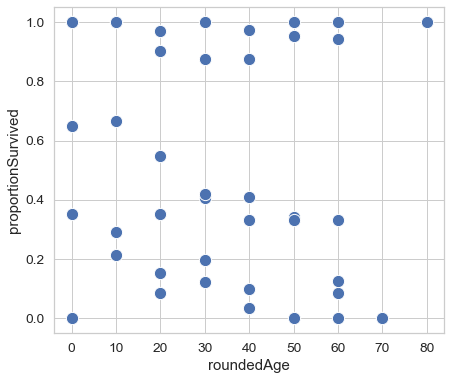

In [9]:
sns.set(rc = {'figure.figsize': (7, 6)},
        font_scale = 1.25) # increase text size on plots (e.g., axis labels)
sns.set_style('whitegrid')

sns.scatterplot(
    x = 'roundedAge',
    y = 'proportionSurvived',
    s = 150, # adjust point size
    data = plotDat)

What do you see?

Now let's re-plot but shape the points relative to passenger sex and color the points relative to passengerClass:

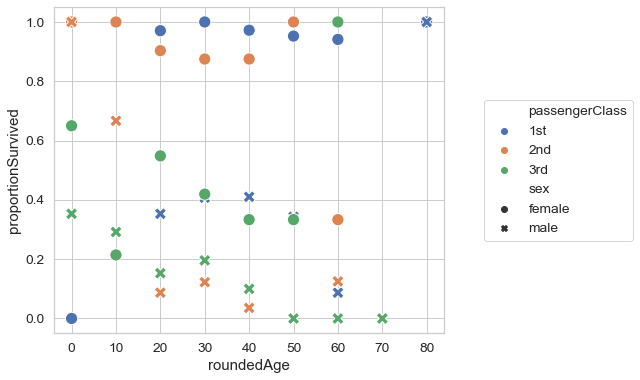

In [10]:
p = sns.scatterplot(
    x = 'roundedAge',
    y = 'proportionSurvived',
    s = 150,
    style = 'sex',
    hue = 'passengerClass',
    data = plotDat)

p.legend(loc = 'center right', bbox_to_anchor = (1.5, 0.5), ncol = 1) # move legend outside of plot

Now what do you see?

Let's re-plot yet again, but this time add faceting by passengerClass rather than using it for color but instead color by sex as well:

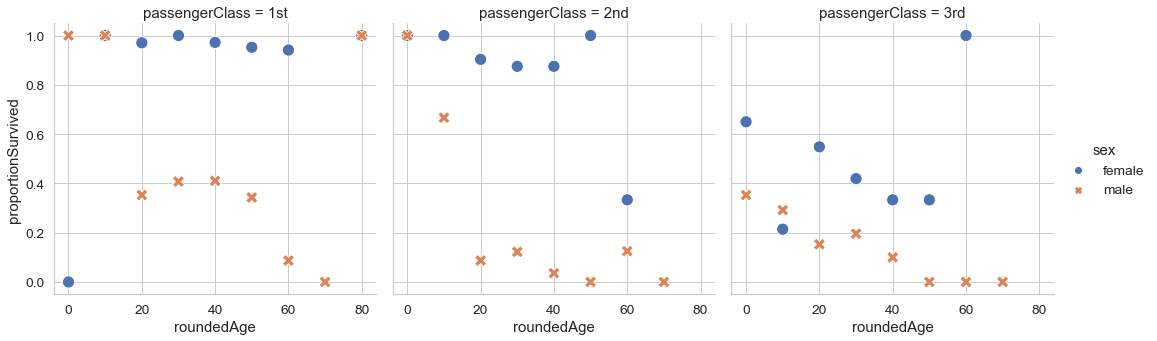

In [11]:
sns.relplot(
    x = 'roundedAge',
    y = 'proportionSurvived',
    s = 150,
    style = 'sex',
    hue = 'sex',
    col = 'passengerClass',
    kind = 'scatter',
    data = plotDat)

Finally, let's re-plot one final time, but this time facet by sex relative to passengerClass:

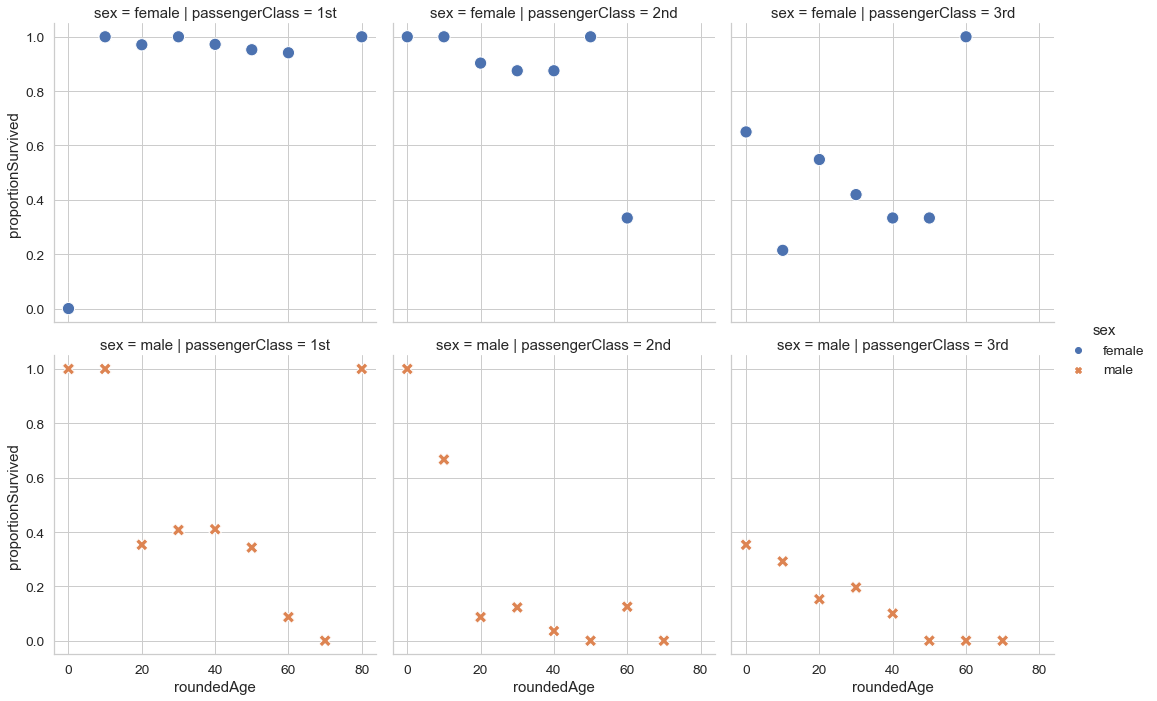

In [12]:
sns.relplot(
    x = 'roundedAge',
    y = 'proportionSurvived',
    s = 150,
    style = 'sex',
    hue = 'sex',
    col = 'passengerClass',
    row = 'sex',
    kind = 'scatter',
    data = plotDat)

What would be your takeaway from the final figure?

## Logistic Regression

To run a logistic regression analysis, we should first consider and handle missing observations:

In [13]:
len(TitanicSurvival)

1309

In [14]:
len(TitanicSurvival.dropna())

1046

In [15]:
round(1 - len(TitanicSurvival.dropna())/len(TitanicSurvival), 3)

0.201

In [16]:
round(TitanicSurvival.isna().sum()/len(TitanicSurvival), 3)

survived          0.000
sex               0.000
age               0.201
passengerClass    0.000
dtype: float64

Approximately 20.1% of the rows have missing data in the age column. While this is a relatively high amount, we still have over 1,000 rows if we perform *listwise deletion* of missing data, so for this example, we'll do so rather than looking into other methods such as imputation:

In [17]:
TitanicSurvivalNoNaNs = TitanicSurvival.dropna()

Now let's look at our dependent variable (DV), survived, and confirm it is actually binomial:

In [18]:
TitanicSurvivalNoNaNs.groupby('survived').size()

survived
no     619
yes    427
dtype: int64

Looks good! Let's also explicitly set the reference level for the DV to make sure our subsequent interpretation is correct:

In [19]:
TitanicSurvivalNoNaNs = (TitanicSurvivalNoNaNs.
                         assign(survived = pd.Categorical(TitanicSurvivalNoNaNs.survived, 
                                                          categories = ['yes', 'no']))) # the resulting coding will be: yes = 1; no = 0

We are now ready to fit some models. We'll be looking at three models based on our predictors passengerClass, sex, and age:

1. all main effects
2. all two-way interactions
3. the full three-way interaction

For this example, we'll use statsmodels' generalized linear models with the formula approach (e.g., see the [documentation](https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html)):

In [20]:
# three main effects
mod1 = smf.glm(formula = 'survived ~ passengerClass + sex + age', data = TitanicSurvivalNoNaNs, family = sm.families.Binomial()).fit()

# all two-way interactions of these three main effects
mod2 = smf.glm(formula = 'survived ~ (passengerClass + sex + age) ** 2', data = TitanicSurvivalNoNaNs, family = sm.families.Binomial()).fit()

# full three-way interaction
mod3 = smf.glm(formula = 'survived ~ passengerClass * sex * age', data = TitanicSurvivalNoNaNs, family = sm.families.Binomial()).fit()

Note that we had options on how to specify the model formulae; for example, in mod2, we use the notation `(passengerClass + sex + age) ** 2`, which expands to all main effects and all two-way interactions for the terms inside the parentheses (i.e., equivalent to: `passengerClass + sex + age + passengerClass:sex + passengerClass:age + sex:age`). For the three-way interaction, we could have also used `(passengerClass + sex + age) ** 3` as an equivalent formula.

Now let's compare these three models:

In [21]:
models = pd.DataFrame({
    'models': ['mod1', 'mod2', 'mod3'],
    'df': [mod1.df_model, mod2.df_model, mod3.df_model],
    'AIC': [mod1.aic, mod2.aic, mod3.aic]})

models['deltaAIC'] = models.AIC - min(models.AIC)

models.sort_values('AIC')

,models,df,AIC,deltaAIC
1,mod2,9,937.843246,0.000000
2,mod3,11,939.977104,2.133857
0,mod1,4,992.453105,54.609859


Among these three, mod2 looks the best based on AIC. Let's look at term-level significance using a Wald test:

In [22]:
mod2.wald_test_terms() # equivalent to car::Anova(mod2, type = 3, test = "Wald")

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


<class 'statsmodels.stats.contrast.WaldTestResults'>
                                       chi2                  P>chi2  df constraint
Intercept            [[17.717926203977363]]  2.5620082410772063e-05              1
passengerClass        [[39.01873095455019]]  3.3665899899969574e-09              2
sex                   [[11.82860287939998]]   0.0005832774292733633              1
passengerClass:sex   [[31.379301905551465]]  1.5348684824496397e-07              2
age                 [[0.05050867877592583]]      0.8221804871296541              1
passengerClass:age     [[9.11987418537228]]    0.010462717104153722              2
sex:age                [[4.30751869749079]]    0.037944268430489814              1

To make this slightly more presentable, let's pull out the table as a pandas DataFrame and add a bit of code to round it:

In [23]:
mod2.wald_test_terms().table.astype({'statistic': 'float', 'pvalue': 'float'}).round(3)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


,statistic,pvalue,df_constraint
Intercept,17.718,0.000,1
passengerClass,39.019,0.000,2
sex,11.829,0.001,1
passengerClass:sex,31.379,0.000,2
age,0.051,0.822,1
passengerClass:age,9.120,0.010,2
sex:age,4.308,0.038,1


Most of the of the terms are significant, but we'll be focusing on interactions to respect the *principle of marginality*. Let's look at the model summary:

In [24]:
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Generalized Linear Model Regression Results                         
=============================================================================================
Dep. Variable:     ['survived[yes]', 'survived[no]']   No. Observations:                 1046
Model:                                           GLM   Df Residuals:                     1036
Model Family:                               Binomial   Df Model:                            9
Link Function:                                 Logit   Scale:                          1.0000
Method:                                         IRLS   Log-Likelihood:                -458.92
Date:                               Tue, 14 Dec 2021   Deviance:                       917.84
Time:                                       22:23:10   Pearson chi2:                 1.22e+03
No. Iterations:                                    6   Pseudo R-squ. (CS):             0.3781
Covariance Type:                           nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             3.3904      0.805      4.209      0.000       1.812       4.969
passengerClass[T.2nd]                 0.7647      0.960      0.797      0.426      -1.117       2.646
passengerClass[T.3rd]                -3.2700      0.765     -4.275      0.000      -4.769      -1.771
sex[T.male]                          -2.5922      0.754     -3.439      0.001      -4.069      -1.115
passengerClass[T.2nd]:sex[T.male]    -0.8788      0.690     -1.274      0.203      -2.231       0.474
passengerClass[T.3rd]:sex[T.male]     1.8857      0.585      3.225      0.001       0.740       3.032
age                                  -0.0040      0.018     -0.225      0.822      -0.038       0.030
passengerClass[T.2nd]:age            -0.0605      0.021     -2.826      0.005      -0.103      -0.019
passengerClass[T.3rd]:age            -0.0062      0.016     -0.386      0.700      -0.038       0.025
sex[T.male]:age                      -0.0314      0.015     -2.075      0.038      -0.061      -0.002
=====================================================================================================
"""

When looking at a summary that includes interaction terms, interpretation can be confusing. For plotting the actual effects, R is preferable. For example, we can re-do this analysis use R via rpy2:

In [25]:
# to install, try: pip install rpy2

# on Windows, you may run into some issues; see the official documentation for help:
# https://rpy2.github.io/doc/latest/html/overview.html#installation 

# on Anaconda, see this support document:
# https://anaconda.zendesk.com/hc/en-us/articles/360023857134-Setting-up-rpy2-on-Windows

from rpy2.robjects.packages import importr
from rpy2 import robjects
from rpy2.robjects import pandas2ri

base = importr('base')
stats = importr('stats')
effects = importr('effects')

df = robjects.r('data.frame')
coef = robjects.r('coef')

pandas2ri.activate() # let's use our existing Python data instead of loading the carData package in R data
robjects.globalenv['TitanicSurvival'] = TitanicSurvival

robjects.r('TitanicSurvival$survived <- factor(TitanicSurvival$survived, levels = c("no", "yes"))')
robjects.r('TitanicSurvival$sex <- factor(TitanicSurvival$sex)')
robjects.r('TitanicSurvival$passengerClass <- factor(TitanicSurvival$passengerClass)')

mod2R = stats.glm('survived ~ (passengerClass + sex + age) ^ 2', data = robjects.globalenv['TitanicSurvival'], family = 'binomial')

coef(mod2R) # compare to the summary results above

array([ 3.39035549,  0.76466654, -3.27000204, -2.59223274, -0.00395004,
       -0.87884096,  1.88569523, -0.06053026, -0.00624392, -0.03137809])

Now we can build our effect plots in Python for each term:

,passengerClass,sex,fit,se,lower,upper
1,1st,female,0.963467,0.016768,0.912027,0.985313
2,2nd,female,0.902760,0.030394,0.824864,0.948186
3,3rd,female,0.454066,0.046643,0.365160,0.546002
4,1st,male,0.435973,0.050854,0.340098,0.536886
5,2nd,male,0.101524,0.026110,0.060573,0.165288


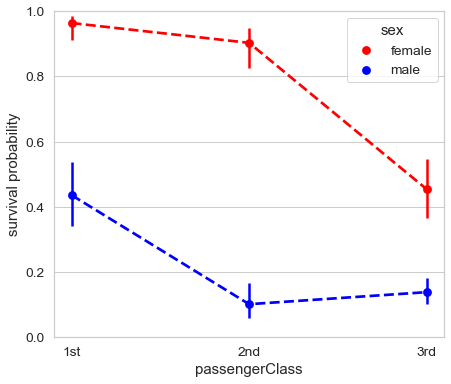

In [26]:
# passengerClass:sex

plotEffect = df(effects.effect('passengerClass:sex', mod2R))
plotEffect[plotEffect.select_dtypes('category').columns] = plotEffect.select_dtypes('category').astype('object').astype('category') # fixes rpy2 issue with NA_character_

display(plotEffect.head())

# define colors
cust_colors = np.array(['red', 'blue'])
sns.set_palette(cust_colors)

# define variables
xVar = 'passengerClass'
groupingVar = 'sex'

plotEffect[xVar] = plotEffect[xVar].astype('str')
plotEffect[groupingVar] = plotEffect[groupingVar].astype('str')

fig = sns.pointplot(x = xVar, 
                    y = 'fit', 
                    hue = groupingVar, 
                    linestyles = '--', 
                    palette = sns.color_palette(), 
                    data = plotEffect)

plt.vlines(x = xVar, 
           ymin = 'lower', 
           ymax = 'upper', 
           color = cust_colors[plotEffect[groupingVar].factorize()[0]], 
           linewidth = 2.5, 
           data = plotEffect)

fig.set(ylabel = 'survival probability', 
        ylim = (0, 1))

fig;

,passengerClass,age,fit,se,lower,upper
1,1st,0.17,0.852664,0.064320,0.679654,0.940426
2,2nd,0.17,0.876227,0.054961,0.723907,0.950284
3,3rd,0.17,0.418437,0.059517,0.308199,0.537472
4,1st,1.90,0.847441,0.063677,0.679032,0.935837
5,2nd,1.90,0.859541,0.057876,0.705142,0.939973


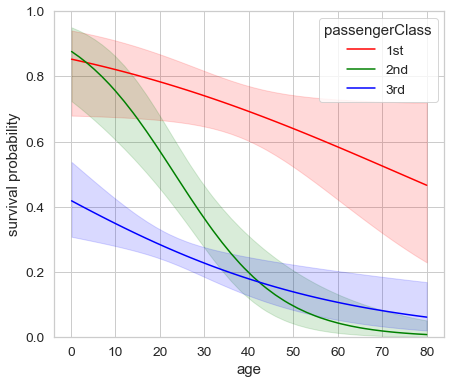

In [27]:
# passengerClass:age

plotEffect = df(effects.effect('passengerClass:age', mod2R, xlevels = 48))
plotEffect[plotEffect.select_dtypes('category').columns] = plotEffect.select_dtypes('category').astype('object').astype('category') # fixes rpy2 issue with NA_character_

display(plotEffect.head())

# define colors
cust_colors = ['red', 'green', 'blue']
sns.set_palette(cust_colors)

# define variables
xVar = 'age'
groupingVar = 'passengerClass'

fig = sns.lineplot(x = xVar, 
                   y = 'fit', 
                   hue = groupingVar, 
                   data = plotEffect)

for i, eachLevel in enumerate(pd.unique(plotEffect[groupingVar])):
    
    # filter shading ribbon by level
    ribbon = plotEffect[plotEffect[groupingVar] == eachLevel]
    
    # plot ribbon for level
    plt.fill_between(x = xVar, 
                     y1 = 'lower', 
                     y2 = 'upper', 
                     color = cust_colors[i], 
                     alpha = 0.15, 
                     data = ribbon)
    
fig.set(ylabel = 'survival probability', 
        ylim = (0, 1));

,sex,age,fit,se,lower,upper
1,female,0.17,0.881966,0.041402,0.774114,0.942170
2,male,0.17,0.524359,0.063857,0.400278,0.645504
3,female,1.90,0.877938,0.040689,0.773619,0.938036
4,male,1.90,0.501273,0.060489,0.384821,0.617587
5,female,3.60,0.873865,0.039925,0.773056,0.933733


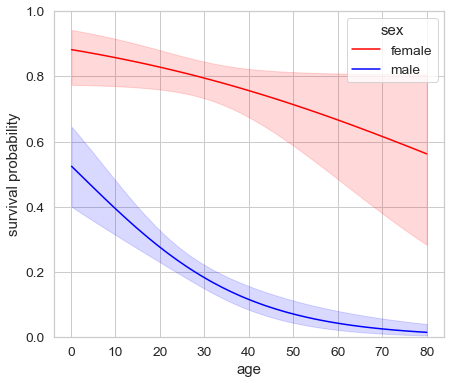

In [28]:
# sex:age

plotEffect = df(effects.effect('sex:age', mod2R, xlevels = 48))
plotEffect[plotEffect.select_dtypes('category').columns] = plotEffect.select_dtypes('category').astype('object').astype('category') # fixes rpy2 issue with NA_character_

display(plotEffect.head())

# define colors
cust_colors = ['red', 'blue']
sns.set_palette(cust_colors)

# define variables
xVar = 'age'
groupingVar = 'sex'

fig = sns.lineplot(x = xVar, 
                   y = 'fit', 
                   hue = groupingVar, 
                   data = plotEffect)

for i, eachLevel in enumerate(pd.unique(plotEffect[groupingVar])):
    
    # filter shading ribbon by level
    ribbon = plotEffect[plotEffect[groupingVar] == eachLevel]
    
    # plot ribbon for level
    plt.fill_between(x = xVar, 
                     y1 = 'lower', 
                     y2 = 'upper', 
                     color = cust_colors[i], 
                     alpha = 0.15, 
                     data = ribbon)
    
fig.set(ylabel = 'survival probability', 
        ylim = (0, 1));

What are your takeaways from the model, particularly in terms of the effect plots?

## Supervised Machine Learning

In the previous section, we fit a series of logistic regression models by hand in an effort to find the best possible model for passenger survival. In this section, we will try to use machine learning to find the best possible model in a more automated fashion. Specifically, we will train multiple models using as many meaningful predictors as are available in an effort to find the optimal predictive model. Note that in this simple example, the number of available predictors is limited (i.e., passengerClass, sex, age); in real-world scenarios, we may have a large number of variables at our disposal, and machine learning can be useful to help find the most useful variables across this larger set. In general, more predictor variables (i.e., features) should be preferred to fewer predictors as long as the predictors are uniquely meaningful and relevant (e.g., not highly correlated with one another).

We will use the scikit-learn ([sklearn](https://scikit-learn.org/stable/index.html)) package to conduct our machine learning analysis.

Before we get started, let's reset our data to make sure its pristine:

In [29]:
sns.set(rc = {'figure.figsize': (7, 6)},
        font_scale = 1.25) # increase text size on plots (e.g., axis labels)
sns.set_style('whitegrid')

ImportTitanicSurvival = sm.datasets.get_rdataset('TitanicSurvival', 'carData', cache = True)

TitanicSurvival = ImportTitanicSurvival.data

display(TitanicSurvival.head(), TitanicSurvival.shape)

,survived,sex,age,passengerClass
"Allen, Miss. Elisabeth Walton",yes,female,29.0000,1st
"Allison, Master. Hudson Trevor",yes,male,0.9167,1st
"Allison, Miss. Helen Loraine",no,female,2.0000,1st
"Allison, Mr. Hudson Joshua Crei",no,male,30.0000,1st
"Allison, Mrs. Hudson J C (Bessi",no,female,25.0000,1st


(1309, 4)

First, we should check class balance for the outcome variable (i.e., survived):

In [30]:
TitanicSurvival.groupby('survived').size()

survived
no     809
yes    500
dtype: int64

In [31]:
round(TitanicSurvival.groupby('survived').size()/len(TitanicSurvival), 3)

survived
no     0.618
yes    0.382
dtype: float64

Looks like about 38.2% of the passengers survived.

Let's create a training and holdout testing set (80%/20% of our data, respectively). We will use the training data to fit and evaluate model performance, while also reserving the holdout testing set for additional model performance comparisons:

In [32]:
Train, Test = train_test_split(TitanicSurvival, 
                               stratify = TitanicSurvival.survived,
                               test_size = 0.20, 
                               random_state = 345)

Let's double check we split correctly:

In [33]:
display(len(Train),
        len(Test))

1047

262

In [34]:
display(round(len(Train)/len(TitanicSurvival), 3), 
        round(len(Test)/len(TitanicSurvival), 3))

0.8

0.2

Now let's check class balance in our training and testing sets (the proportions should be approximately identical because we used the *stratify* argument in **train_test_split** above -- they should also match the overarching proportion we saw in the complete data set earlier):

In [35]:
display(Train.groupby('survived').size())
round(Train.groupby('survived').size()/len(Train), 3)

survived
no     647
yes    400
dtype: int64

survived
no     0.618
yes    0.382
dtype: float64

In [36]:
display(Test.groupby('survived').size())
round(Test.groupby('survived').size()/len(Test), 3)

survived
no     162
yes    100
dtype: int64

survived
no     0.618
yes    0.382
dtype: float64

Several machine learning models perform better when training models when classes are balanced. There are many ways to accomplish this (e.g., SMOTE), but as long as there is a sufficient amount of data, the easiest is to simply down sample the training data to balance based on the minority class (i.e., the class with fewer observations):

In [37]:
np.random.seed(345) # to create reproducible results

maj_class = np.where(Train.survived == 'no')[0]
min_class = np.where(Train.survived == 'yes')[0]

resample = np.random.choice(maj_class, size = len(min_class), replace = False)

TrainDS = pd.concat([Train.iloc[min_class], Train.iloc[resample]])

TrainDS.shape

(800, 4)

Let's double check the result:

In [38]:
display(TrainDS.groupby('survived').size())
round(TrainDS.groupby('survived').size()/len(TrainDS), 3)

survived
no     400
yes    400
dtype: int64

survived
no     0.5
yes    0.5
dtype: float64

In [39]:
Image(url = 'https://i.kym-cdn.com/entries/icons/original/000/027/257/perfectly-balanced-as-all-things-should-be.jpg') # from https://knowyourmeme.com/memes/perfectly-balanced

Now let's check for missing values in data, which some models cannot handle:

In [40]:
round(1 - len(TrainDS.dropna())/len(TrainDS), 3)

0.194

Approximately 19.4% missing in the training data at large. Let's also look at this by column:

In [41]:
round(TrainDS.isna().sum()/len(TrainDS), 3)

survived          0.000
sex               0.000
age               0.194
passengerClass    0.000
dtype: float64

Clearly we do have a fair amount of missing data, albeit limited to one column in this case. As noted above, some models such as decision trees can handle missing data just fine. Others such as support vector machines (SVM) cannot. For this example, let's go ahead and do some preprocessing of the data to:

1. impute missing numeric data using column medians
2. impute missing categorical data using a constant
3. *one hot encode* the categorical data to make them binary
4. remove any predictors that happen to have zero variance

Regarding the first point, it's worth noting that there are many other ways to handle missing data besides median imputation, which is a very simplistic approach. For more on this topic, see the relevant sklearn [documentation](https://scikit-learn.org/stable/modules/impute.html).

Let's start with median imputation for the numeric data (i.e., age):

In [42]:
display(TrainDS.head(), TrainDS.dtypes)

,survived,sex,age,passengerClass
"Pickard, Mr. Berk (Berk Trembis",yes,male,32.0,3rd
"Mamee, Mr. Hanna",yes,male,NaN,3rd
"Hakkarainen, Mrs. Pekka Pietari",yes,female,24.0,3rd
"Harper, Mrs. Henry Sleeper (Myn",yes,female,49.0,1st
"Kimball, Mr. Edwin Nelson Jr",yes,male,42.0,1st


survived           object
sex                object
age               float64
passengerClass     object
dtype: object

In [43]:
imp_median = SimpleImputer(missing_values = np.nan, 
                           strategy = 'median')

# note: explicitly ignore the target column (i.e., survived) and object/category columns
imp_raw_data_train = TrainDS.drop(columns = 'survived').select_dtypes(exclude = ['object', 'category'])

imp_median = imp_median.fit(imp_raw_data_train)

imputed_data_train = pd.DataFrame(imp_median.transform(imp_raw_data_train))

imputed_data_train.columns = imp_raw_data_train.columns
imputed_data_train.index = imp_raw_data_train.index

TrainDS_Imp = pd.concat([TrainDS.drop(imp_raw_data_train.columns, axis = 1), imputed_data_train], axis = 1)

TrainDS_Imp.head()

,survived,sex,passengerClass,age
"Pickard, Mr. Berk (Berk Trembis",yes,male,3rd,32.0
"Mamee, Mr. Hanna",yes,male,3rd,28.0
"Hakkarainen, Mrs. Pekka Pietari",yes,female,3rd,24.0
"Harper, Mrs. Henry Sleeper (Myn",yes,female,1st,49.0
"Kimball, Mr. Edwin Nelson Jr",yes,male,1st,42.0


Notice the missing case of age has now been replaced with the median, leaving us with no missing data:

In [44]:
round(1 - len(TrainDS_Imp.dropna())/len(TrainDS_Imp), 3)

0.0

Based on the second row, the imputed value for age based on the training data is `28.0`, which we can verify by hand as well:

In [45]:
np.nanmedian(TrainDS.age)

28.0

Because sex was the only column with missing data as we saw earlier, we're technically done with imputation at this point.

However, assuming we needed to resolve missing data involving categorical columns, we could also use [***SimpleImputer***](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) by incorporating a different *strategy* such as `'most_frequent'` or `'constant'` replacement as outlined [here](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation). In this case, we will use the latter, although for these data, it ultimately won't change anything since none of the categorical data are missing. Nevertheless, the following code may serve as a useful example:

In [46]:
imp_constant = SimpleImputer(missing_values = np.nan, 
                             strategy = 'constant')

# note: explicitly ignore the target column (i.e., survived) and include only object/category columns
imp_raw_data_train = TrainDS_Imp.drop(columns = 'survived').select_dtypes(include = ['object', 'category'])

imp_constant = imp_constant.fit(imp_raw_data_train)

imputed_data_train = pd.DataFrame(imp_constant.transform(imp_raw_data_train))

imputed_data_train.columns = imp_raw_data_train.columns
imputed_data_train.index = imp_raw_data_train.index

TrainDS_ImpConst = pd.concat([TrainDS_Imp.drop(imp_raw_data_train.columns, axis = 1), imputed_data_train], axis = 1)

TrainDS_ImpConst.head()

,survived,age,sex,passengerClass
"Pickard, Mr. Berk (Berk Trembis",yes,32.0,male,3rd
"Mamee, Mr. Hanna",yes,28.0,male,3rd
"Hakkarainen, Mrs. Pekka Pietari",yes,24.0,female,3rd
"Harper, Mrs. Henry Sleeper (Myn",yes,49.0,female,1st
"Kimball, Mr. Edwin Nelson Jr",yes,42.0,male,1st


Next let's take care of dummy encoding (i.e., one hot encoding) the categorical data:

In [47]:
enc = OneHotEncoder(handle_unknown = 'ignore', 
                    sparse = False)

enc_raw_data_train = TrainDS_ImpConst.drop(columns = 'survived').select_dtypes(include = ['object', 'category'])

enc = enc.fit(enc_raw_data_train)

encoded_data_train = pd.DataFrame(enc.transform(enc_raw_data_train))

encoded_data_train.columns = enc.get_feature_names_out(enc_raw_data_train.columns)
encoded_data_train.index = enc_raw_data_train.index

TrainDS_ImpConstEnc = pd.concat([TrainDS_ImpConst.drop(enc_raw_data_train.columns, axis = 1), encoded_data_train], axis = 1)

TrainDS_ImpConstEnc.head()

,survived,age,sex_female,sex_male,passengerClass_1st,passengerClass_2nd,passengerClass_3rd
"Pickard, Mr. Berk (Berk Trembis",yes,32.0,0.0,1.0,0.0,0.0,1.0
"Mamee, Mr. Hanna",yes,28.0,0.0,1.0,0.0,0.0,1.0
"Hakkarainen, Mrs. Pekka Pietari",yes,24.0,1.0,0.0,0.0,0.0,1.0
"Harper, Mrs. Henry Sleeper (Myn",yes,49.0,1.0,0.0,1.0,0.0,0.0
"Kimball, Mr. Edwin Nelson Jr",yes,42.0,0.0,1.0,1.0,0.0,0.0


Finally, just in case we have columns with no variance, we can remove them using a variance threshold approach:

In [48]:
selector = VarianceThreshold()

sel_raw_data_train = TrainDS_ImpConstEnc.drop(columns = 'survived')

selector = selector.fit(sel_raw_data_train)

selected_data_train = sel_raw_data_train.iloc[:, selector.get_support(indices = True)]

TrainDS_ImpConstEncSel = pd.concat([TrainDS_ImpConstEnc.drop(sel_raw_data_train.columns, axis = 1), selected_data_train], axis = 1)

TrainDS_ImpConstEncSel.head()

,survived,age,sex_female,sex_male,passengerClass_1st,passengerClass_2nd,passengerClass_3rd
"Pickard, Mr. Berk (Berk Trembis",yes,32.0,0.0,1.0,0.0,0.0,1.0
"Mamee, Mr. Hanna",yes,28.0,0.0,1.0,0.0,0.0,1.0
"Hakkarainen, Mrs. Pekka Pietari",yes,24.0,1.0,0.0,0.0,0.0,1.0
"Harper, Mrs. Henry Sleeper (Myn",yes,49.0,1.0,0.0,1.0,0.0,0.0
"Kimball, Mr. Edwin Nelson Jr",yes,42.0,0.0,1.0,1.0,0.0,0.0


That takes care of the three preprocessing steps we discussed above. However, it's important to note there are other considerations for preprocessing that may influence model performance, such as centering/scaling, which are easy to perform in sklearn as described [here](https://scikit-learn.org/stable/modules/preprocessing.html). However, note that while some models often/typically benefit from centering/scaling (e.g., k-means clustering, SVM), other models such as tree models do not require it (and performing centering/scaling makes interpretation potentially more complicated for these types of models). Moreover, if all the predictor data were already on the same scale (e.g., a series of Likert scale items), then centering/scaling may actually be counterproductive in terms of model performance, and occasionally centering/scaling may lead to worse model performance with a given set of predictors. In other words, there is no one-size-fits-all solution when it comes to machine learning such as "always center/scale": always consider the data/models when making preprocessing decisions, and when in doubt, try fitting models with and without various preprocessing steps performed to compare the impact on the results.

Now, before we move on, we need to apply all of the preprocessing we performed earlier using the training data to the testing data as well so that we can evaluate our models later in the script. It's important to recognize the test data is being preprocessed using values from the training data to avoid *data leakage*. Moreover, unlike the training data, the test data was ***not*** downsampled!

In [49]:
Test.head()

,survived,sex,age,passengerClass
"Risien, Mrs. Samuel (Emma)",no,female,NaN,3rd
"Sadlier, Mr. Matthew",no,male,NaN,3rd
"Widener, Mr. George Dunton",no,male,50.0,1st
"Daly, Miss. Margaret Marcella",yes,female,30.0,3rd
"Bryhl, Mr. Kurt Arnold Gottfrid",no,male,25.0,2nd


In [50]:
# median imputation (for numeric data)

imp_raw_data_test = Test.drop(columns = 'survived').select_dtypes(exclude = ['object', 'category'])

imputed_data_test = pd.DataFrame(imp_median.transform(imp_raw_data_test))

imputed_data_test.columns = imp_raw_data_test.columns
imputed_data_test.index = imp_raw_data_test.index

Test_Imp = pd.concat([Test.drop(imp_raw_data_test.columns, axis = 1), imputed_data_test], axis = 1)

# constant imputation (for categorical data)

imp_raw_data_test = Test_Imp.drop(columns = 'survived').select_dtypes(include = ['object', 'category'])

imputed_data_test = pd.DataFrame(imp_constant.transform(imp_raw_data_test))

imputed_data_test.columns = imp_raw_data_test.columns
imputed_data_test.index = imp_raw_data_test.index

Test_ImpConst = pd.concat([Test_Imp.drop(imp_raw_data_test.columns, axis = 1), imputed_data_test], axis = 1)

# one hot encoding (for categorical data)

enc_raw_data_test = Test_ImpConst.drop(columns = 'survived').select_dtypes(include = ['object', 'category'])

encoded_data_test = pd.DataFrame(enc.transform(enc_raw_data_test))

encoded_data_test.columns = enc.get_feature_names_out(enc_raw_data_test.columns)
encoded_data_test.index = enc_raw_data_test.index

Test_ImpConstEnc = pd.concat([Test_ImpConst.drop(enc_raw_data_test.columns, axis = 1), encoded_data_test], axis = 1)

# final result

Test_ImpConstEnc.head()

,survived,age,sex_female,sex_male,passengerClass_1st,passengerClass_2nd,passengerClass_3rd
"Risien, Mrs. Samuel (Emma)",no,28.0,1.0,0.0,0.0,0.0,1.0
"Sadlier, Mr. Matthew",no,28.0,0.0,1.0,0.0,0.0,1.0
"Widener, Mr. George Dunton",no,50.0,0.0,1.0,1.0,0.0,0.0
"Daly, Miss. Margaret Marcella",yes,30.0,1.0,0.0,0.0,0.0,1.0
"Bryhl, Mr. Kurt Arnold Gottfrid",no,25.0,0.0,1.0,0.0,1.0,0.0


That takes care of applying the various data cleaning methods generated using the training data to the test date (note that it's not necessary to perform zero variance removal for the test data since the additional columns are irrelevant when it comes to generating test predictions).

Now let's fit several tree-based machine learning models including:

1. [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
2. [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
3. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Before we get started, let's discuss the issue of *hyperparameter tuning*, which are model-specific settings that can influence prediction results (e.g., accuracy). To see what parameters a model supports, use the ***get_params*** method; for example, for a [*decision tree*](https://scikit-learn.org/stable/modules/tree.html) classifer, we can use:

In [51]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Additional information regarding these model-specific parameters can be found via ***help*** (e.g., `help(DecisionTreeClassifier)`) or via a Google search.

A common question that often comes up when training and tuning models is what settings to use to yield the best performance. The answer to this question is two-fold:

1. in terms of default/starting settings, there are often rule-of-thumb defaults that often come out of the literature on machine learning; for example, for random forest models, the recommended number of trees for classification problems is $\sqrt{p}$, where $p$ is the number of parameters in the data (e.g., see [The Elements of
Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/))
2. realistically, the best settings depend upon the data, so you'll need to try various combinations of settings to see what works best

Conveniently, sklearn provides a variety of functions to streamline the model tuning process as documented [here](https://scikit-learn.org/stable/modules/grid_search.html). For this tutorial, we'll focus on the *grid search* approach, which involves sequentally evaluating setting combinations to find the optima. Specifically, we'll be using the [***GridSearchCV***](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) function, which uses [*cross-validation*](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) (a resampling procedure) to exhaustively evaluate different settings from a set of predefined options. After testing all of the parameter combinations, it will ultimately find and utilize the setting with the best predictive performance based on a selected [*evaluation metric*](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) such as *balanced accuracy* or *receiver operater charactertistic (ROC) area under the curve (AUC)* -- for details on these, see the following section of the sklearn [guide](https://scikit-learn.org/stable/modules/model_evaluation.html).

Let's see this using our data:

In [52]:
# set up data
X_train = TrainDS_ImpConstEncSel.drop(columns = 'survived')
y_train = TrainDS_ImpConstEncSel.survived

X_test = Test_ImpConstEnc.drop(columns = 'survived')
y_test = Test_ImpConstEnc.survived

# set up outcome labels
labels = {'no': 0,
          'yes': 1}

# set up scoring metric
scoring_metric = 'balanced_accuracy'

# set up classifiers and tuning parameters
names = ['Decision Tree', 'AdaBoost', 'Random Forest']
classifiers = [DecisionTreeClassifier(random_state = 345), 
               AdaBoostClassifier(random_state = 345), 
               RandomForestClassifier(random_state = 345)]
param_grids = [{'max_depth': [2, 3, 4], 'criterion': ['gini', 'entropy']}, 
               {'n_estimators': [25, 50, 100, 150, 300]}, 
               {'max_depth': [2, 3, 4], 'max_features': [None, 'sqrt', 'log2'], 'n_estimators': [50, 100, 150]}]

# create empty lists for storing outcomes
models = []
preds = []
probs = []
BAs = []
AUCs = []
FPRs = []
TPRs = []
timings = []

# relabel outcome variable with integers for compatibility (e.g., for xgboost)
y_train = y_train.replace(labels)
y_test = y_test.replace(labels)

# train classifiers and generate test predictions/probabilities
for i, eachClassifier in enumerate(classifiers):
    
    print('Now working on model ', i + 1, ' of ', len(classifiers), ': ', names[i], sep = '')
    
    # define cross-validation/parameter tuning settings
    search = GridSearchCV(eachClassifier, 
                          param_grids[i], 
                          cv = 5, # using (Stratified)KFold by default (with 5 folds)
                          scoring = scoring_metric,
                          n_jobs = -1) # use parallel processing
    
    model = search.fit(X_train, y_train)
    pred = search.predict(X_test)
    prob = search.predict_proba(X_test)[:, 1]
    
    models.append(model)
    preds.append(pred)
    probs.append(prob)
    
    BAs.append(balanced_accuracy_score(y_test, pred))
    AUCs.append(roc_auc_score(y_test, prob))
    
    FPR, TPR, _ = roc_curve(y_test, prob)
    
    FPRs.append(FPR)
    TPRs.append(TPR)
    
    timings.append(model.refit_time_)
    
print('Finished!')

Now working on model 1 of 3: Decision Tree
Now working on model 2 of 3: AdaBoost
Now working on model 3 of 3: Random Forest
Finished!


Now we can create a DataFrame of our results, sorted by the highest (i.e., best) balanced accuracy/AUC score on the testing data:

In [53]:
results = pd.DataFrame({'Classifier': names, 
                        'Balanced Accuracy': BAs, 
                        'AUC': AUCs, 
                        'TPR': TPRs, 
                        'FPR': FPRs, 
                        'Refit Time': timings}).sort_values(['Balanced Accuracy', 'AUC'], ascending = False)

display(results[['Classifier', 'Refit Time', 'Balanced Accuracy', 'AUC']].round(3))

,Classifier,Refit Time,Balanced Accuracy,AUC
2,Random Forest,0.093,0.772,0.839
0,Decision Tree,0.009,0.768,0.832
1,AdaBoost,0.161,0.748,0.814


We can also plot these data to see which model performed best (e.g., based on AUC), colored relative to model refit time (where lower, <font color = 'green'>**greener**</font> times are better):

/var/folders/g0/w4d4cqfj3cgchjzwlrlfdj740000gq/T/ipykernel_22157/1770620105.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(smRTs)


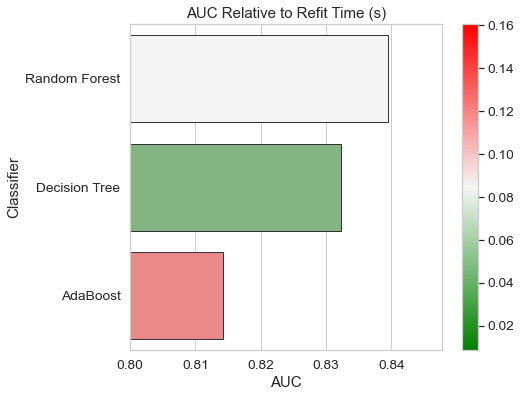

In [54]:
greenToRed = LinearSegmentedColormap.from_list('', ['green', 'whitesmoke', 'red'])
cm.register_cmap('green_to_red', greenToRed)

normRTs = plt.Normalize(results['Refit Time'].min(), results['Refit Time'].max())
smRTs = plt.cm.ScalarMappable(cmap = 'green_to_red', norm = normRTs)

ax = sns.barplot(y = 'Classifier', 
                 x = 'AUC', 
                 hue = 'Refit Time', 
                 dodge = False, 
                 palette = 'green_to_red', 
                 edgecolor = '.2', 
                 data = results)

ax.get_legend().remove()
ax.figure.colorbar(smRTs)
ax.set(title = 'AUC Relative to Refit Time (s)')
ax.set(xlim = (math.floor(results.AUC.min() * 10) * 10/100, 
               results.AUC.max() * 1.01))

plt.show()

We can also compare our models visually by plotting the *receiver operating characteristic (ROC)* curves for each model:

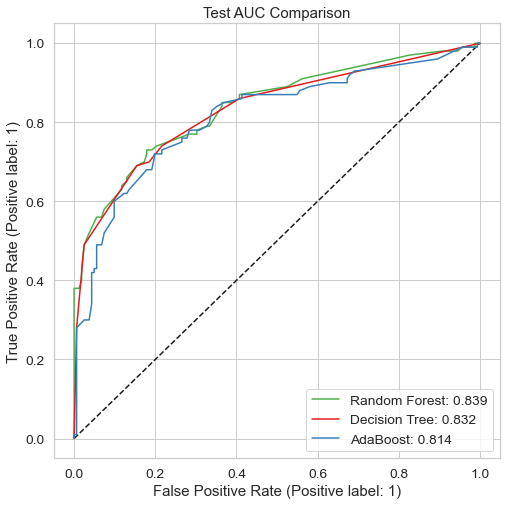

In [55]:
# defining a custom function for reuse later
def Custom_ROC_Plot (results, X_test, y_test, title, figwidth = 8, figheight = 8):

    fig, ax = plt.subplots(figsize = (figwidth, figheight))

    ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
    ax.set(title = title)

    for i in results.index:
        RocCurveDisplay.from_estimator(models[i], 
                                       X_test, 
                                       y_test, 
                                       color = cm.Set1(i), 
                                       label = results.loc[i, 'Classifier'] + ': {:.3f}'.format(results.loc[i, 'AUC']), 
                                       ax = ax)
        
    return([fig, ax])

fig, ax = Custom_ROC_Plot(results, X_test, y_test, title = 'Test AUC Comparison')

Overall these models all perform pretty similarly and are within rounding error of each other -- realistically, any of them would suit us well, but we'll stick with the random forest since it has the highest AUC (despite also having a somewhat long refit time -- albiet with these timing differences measured in milliseconds in this case).

Let's now pull out the index of our best model from our results (i.e., the first index from the DataFrame, since it was sorted by descending AUC):

In [56]:
best_index = results.index[0]

Using this, we can pull up details regarding the best model that resulted from our tuning procedure:

In [57]:
models[best_index].best_estimator_

RandomForestClassifier(max_depth=3, max_features='sqrt', n_estimators=50,
                       random_state=345)

If desired, we can also pull up some additional details regarding our model tuning process (e.g., to see how different parameters performed during the tuning process):

In [58]:
tuning_results = pd.DataFrame(models[best_index].cv_results_).sort_values('rank_test_score')

tuning_results.round(3).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.247,0.005,0.025,0.002,3,log2,50,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.862,0.775,0.788,0.775,0.719,0.784,0.046,1
12,0.240,0.008,0.028,0.004,3,sqrt,50,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",0.862,0.775,0.788,0.775,0.719,0.784,0.046,1
13,0.465,0.007,0.043,0.003,3,sqrt,100,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",0.862,0.775,0.788,0.756,0.719,0.780,0.047,3
16,0.474,0.003,0.044,0.003,3,log2,100,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.862,0.775,0.788,0.756,0.719,0.780,0.047,3
17,0.739,0.024,0.074,0.010,3,log2,150,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.862,0.775,0.781,0.756,0.719,0.779,0.047,5


This DataFrame shows the results of each hyperparameter combination we investigated earlier for our best model, sorted in descending order by best rank_test_score (which is really just the ranking based on the mean_test_score column [i.e., balanced accuracy from the model fitting process we conducted earlier]).

Note that here we are only looking at the head of the DataFrame. In reality, there are 27 rows to represent the combination of all the different features we explored (i.e., max_depth [2, 3, 4] x max_features [None, sqrt, log2] x n_estimators [50, 100, 150] = 3 * 3 * 3 = 27 total):

In [59]:
len(tuning_results)

27

Now let's plot a confusion matrix for our top model:

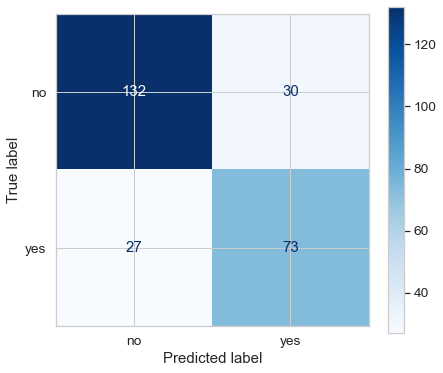

In [60]:
# note: for a simple printed matrix, you can use:
# confusion_matrix(y_test, preds[best_index])

ConfusionMatrixDisplay.from_estimator(models[best_index], 
                                      X_test, 
                                      y_test,
                                      cmap = plt.cm.Blues,
                                      values_format = 'd',
                                      display_labels = labels)

Using the confusion matrix and various formulas, we can compute a variety of additional [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) regarding our model. For example, we can compute a variety of metrics by hand using basic formulas:

In [61]:
TP = 73  # True Positive
TN = 132 # True Negative
FP = 30  # False Positive
FN = 27  # False Negative

test_metrics = pd.DataFrame({
    'Sensitivity': [TP/(TP+FN)], 
    'Specificity': [TN/(TN+FP)], 
    'Positive Predictive Value': [TP/(TP+FP)], 
    'Negative Predictive Value': [TN/(TN+FN)], 
    'F1 Score': [TP/(TP+.5*(FP+FN))], 
    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)]})

test_metrics['Balanced Accuracy'] = np.mean([test_metrics.Sensitivity, test_metrics.Specificity])

test_metrics.round(3)

,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1 Score,Accuracy,Balanced Accuracy
0,0.73,0.815,0.709,0.83,0.719,0.782,0.772


Unsurprisingly, these calculations line up perfectly with some we've already calculated previously. For example, compare the balanced accuracy metric shown above to the one we initially looked at right after model fitting:

In [62]:
results.loc[best_index, ['Classifier', 'Balanced Accuracy']]

Classifier           Random Forest
Balanced Accuracy         0.772407
Name: 2, dtype: object

This calculation was made using the [***balanced_accuracy_score***](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score) function, and several other predefined [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html) functions are also available to quickly calculate a variety of useful metrics. For example:

In [63]:
# sensitivity (i.e., recall for the positive class)
recall_score(y_test, preds[best_index], pos_label = 1).round(3)

0.73

In [64]:
# specificity (i.e., recall for the negative class)
recall_score(y_test, preds[best_index], pos_label = 0).round(3)

0.815

In [65]:
# f1 score
f1_score(y_test, preds[best_index], pos_label = 1).round(3)

0.719

In [66]:
# accuracy
accuracy_score(y_test, preds[best_index]).round(3)

0.782

In [67]:
# balanced accuracy
balanced_accuracy_score(y_test, preds[best_index]).round(3)

0.772

To see a number of these evaluation metrics all at once, you can generate a classification report:

In [68]:
print(classification_report(y_test, preds[best_index], digits = 3))

              precision    recall  f1-score   support

           0      0.830     0.815     0.822       162
           1      0.709     0.730     0.719       100

    accuracy                          0.782       262
   macro avg      0.769     0.772     0.771       262
weighted avg      0.784     0.782     0.783       262



Finally, to better understand the model, we can also plot the most important features:

<AxesSubplot:xlabel='importance', ylabel='feature'>

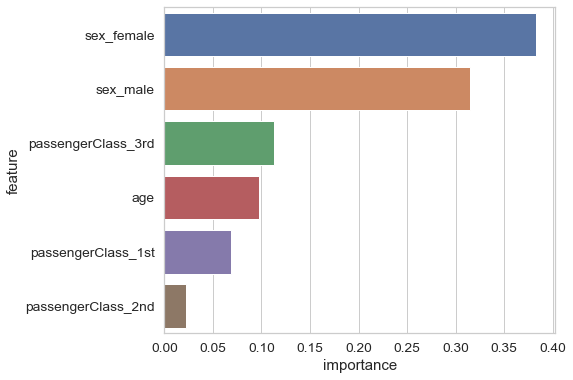

In [69]:
# for models with feature importances
if hasattr(models[best_index].best_estimator_, 'feature_importances_'):
    var_imp = pd.DataFrame({
        'feature': X_test.columns, 
        'importance': models[best_index].best_estimator_.feature_importances_}).sort_values('importance', ascending = False)
# for models with coefficients (directional) -- note: for interpretation and potential caveats, see https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
elif hasattr(models[best_index].best_estimator_, 'coef_'):
    var_imp = pd.DataFrame({
        'feature': X_test.columns, 
        'importance_abs': abs(models[best_index].best_estimator_.coef_[0]), 
        'importance': models[best_index].best_estimator_.coef_[0]}).sort_values('importance_abs', ascending = False)
# for other cases raise an error
else:
    raise Exception('Requested model does not have feature_importances_ or coef_ attribute.')
    
sns.barplot(y = 'feature', 
            x = 'importance', 
            data = var_imp.head(10))

How do these results compare to what we saw earlier?

### Plotting Decision Trees

While not our top model, let's quickly plot the decision tree model as well since sklearn makes it relatively [easy](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html), although you'll need to install [Graphviz](https://www.graphviz.org/) outside of Python as well for this to work:

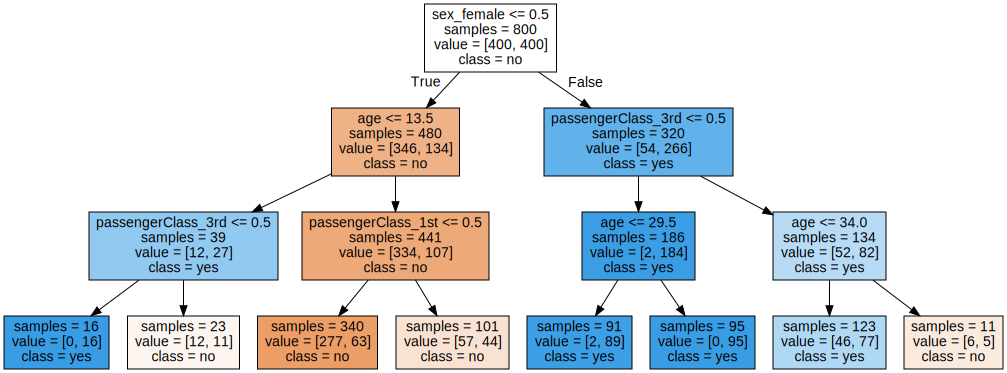

In [70]:
# note that for this to work you'll need to:
# 1) install via conda/pip the Python graphviz package(s): graphviz and possibly python-graphviz
# 2) the Graphviz software (see https://www.graphviz.org/download/; for macOS, I suggest homebrew: https://formulae.brew.sh/formula/graphviz)

from IPython.display import SVG
from graphviz import Source

DecisionTree = models[results.query('Classifier == "Decision Tree"').index[0]].best_estimator_

graph = Source(tree.export_graphviz(DecisionTree, 
                                    out_file = None, 
                                    feature_names = X_test.columns, 
                                    class_names = list(labels.keys()), 
                                    impurity = False, 
                                    proportion = False, 
                                    filled = True))

SVG(graph.pipe(format = 'svg'))

## Comparing Methods

Out of curiosity, let's compare the results of our best machine learning classifier to the logistic regression model we fit earlier. First, let's tweak the same test data using pandas for simplicity:

In [71]:
Test.head() # missing data

,survived,sex,age,passengerClass
"Risien, Mrs. Samuel (Emma)",no,female,NaN,3rd
"Sadlier, Mr. Matthew",no,male,NaN,3rd
"Widener, Mr. George Dunton",no,male,50.0,1st
"Daly, Miss. Margaret Marcella",yes,female,30.0,3rd
"Bryhl, Mr. Kurt Arnold Gottfrid",no,male,25.0,2nd


In [72]:
display(TrainDS.select_dtypes('number').median())

TestNoNaN = Test.fillna(Train.select_dtypes('number').median()) # here we impute the train median into the test

display(TestNoNaN.head()) # median imputed

age    28.0
dtype: float64

,survived,sex,age,passengerClass
"Risien, Mrs. Samuel (Emma)",no,female,28.0,3rd
"Sadlier, Mr. Matthew",no,male,28.0,3rd
"Widener, Mr. George Dunton",no,male,50.0,1st
"Daly, Miss. Margaret Marcella",yes,female,30.0,3rd
"Bryhl, Mr. Kurt Arnold Gottfrid",no,male,25.0,2nd


To ensure this comparison is a fair, let's refit it using just the downsampled training data for a relatively apples-to-apples comparison. Before we fit the model, let's ensure the levels are set in the desired order (similar to what we did earlier):

In [73]:
TrainDS = TrainDS.assign(survived = pd.Categorical(TrainDS.survived, categories = ['yes', 'no']))

Now we'll use the `mod2` we fit earlier to make predictions:

In [74]:
mod2train = smf.glm(formula = mod2.model.formula, data = TrainDS, family = sm.families.Binomial()).fit()

Now we'll use this refit model to generate predictions:

In [75]:
mod2_prob = mod2train.predict(TestNoNaN)
mod2_prob

Risien, Mrs. Samuel (Emma)         0.607812
Sadlier, Mr. Matthew               0.232358
Widener, Mr. George Dunton         0.325471
Daly, Miss. Margaret Marcella      0.607453
Bryhl, Mr. Kurt Arnold Gottfrid    0.175762
                                     ...   
West, Mr. Edwy Arthur              0.044718
Braf, Miss. Elin Ester Maria       0.609247
McCoy, Mr. Bernard                 0.232358
Kallio, Mr. Nikolai Erland         0.309957
Carlsson, Mr. Frans Olof           0.532186
Length: 262, dtype: float64

These values are equivalent to prediction probabilities; to get the class labels, we can use numpy:

In [76]:
mod2_pred = np.where(mod2_prob >= .5, 'yes', 'no')

mod2_pred[0:20]

array(['yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes',
       'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes'],
      dtype='<U3')

Now let's compare the AUC:

In [77]:
mod2_auc = roc_auc_score(y_test, mod2_prob).round(3)
mod2_auc

0.828

Very comparable to the machine learning models overall:

In [78]:
display(results[['Classifier', 'AUC']])

,Classifier,AUC
2,Random Forest,0.839414
0,Decision Tree,0.832346
1,AdaBoost,0.814228


We can also quickly check the confusion matrix using the class predictions:

In [79]:
confusion_matrix(y_test, np.where(mod2_pred == 'yes', 1, 0)) # note: we recode yes/no to 1/0, respectively

array([[119,  43],
       [ 24,  76]])

Finally, let's compare the ROC plots by recycling code from earlier:

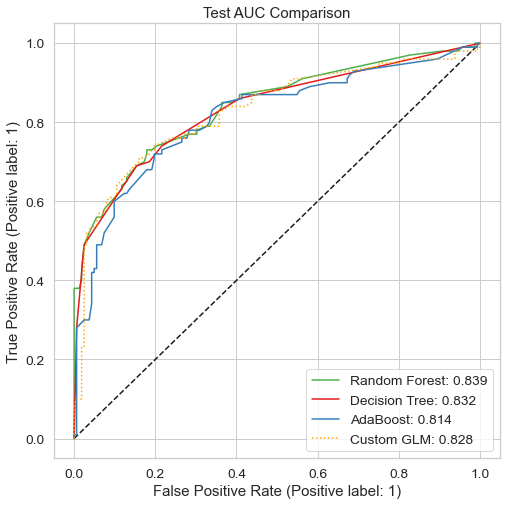

In [80]:
fig, ax = Custom_ROC_Plot(results, X_test, y_test, title = 'Test AUC Comparison')

mod2_FPR, mod2_TPR, _ = roc_curve(y_test, mod2_prob)

pyplot.plot(mod2_FPR, 
            mod2_TPR,
            linestyle = ':', 
            color = 'orange', 
            label = 'Custom GLM: {:.3f}'.format(mod2_auc))

ax.legend()